# "1001 Movies..." Progress


In [0]:
from bs4 import BeautifulSoup
import requests
from datetime import datetime, date 
from tabulate import tabulate #to export dataframe as markdown table
from dateutil.relativedelta import relativedelta
import pandas as pd

In [0]:
lastMonth=True  # the markdown table will be for last month
                # change to false to report in the current month
whoami='jasmineelm' #your letterboxd username

#show these columns in the final table
showColumns={
    'Year':True ,
    'Rating' :True,
    'Seen Before' :True,
    }

In [0]:
##download, and parse the 1001 movies list

url ='https://gist.githubusercontent.com/JasmineElm/ce8219c58bd416c0aec588a97e168221/raw/a109d4d78834a0426779fb8e9588448022458b39/gistfile1.csv'
r = requests.get(url)
filename = url.split('/')[-1]
 
with open(filename,'wb') as output_file:
    output_file.write(r.content)

df=pd.read_csv(filename,index_col=[0])


In [0]:
#download, parse watched list

##start by building a list of the diary pages
letterboxd='https://letterboxd.com/'+whoami+'/films/diary/'
linkList=[]
diary = requests.get(letterboxd)
soup = BeautifulSoup(diary.text, "html.parser")

rawlist=soup.find_all("li",{"class":"paginate-page"})
for link in soup.find_all("li",{"class":"paginate-page"}):

  if link.a != None: #ignore list items which don't have an 'a' tag.
    upperBound=int(str(link.a.contents[0]))

for i in range(1, upperBound+1):
  linkList.append(letterboxd+'page/'+ str(i)+"/")

# generate a list of diary entries.
# each inner list represents a single viewing of a film
newList=[]
for page in linkList:
  diary = requests.get(page)
  soup = BeautifulSoup(diary.text, "html.parser") 

  for itm in soup.find_all("tr",{"class":"diary-entry-row"}):
    innerlist=[]
    date= datetime.strptime(itm.find("td",{"class":"td-day diary-day center"}).a['href'][-11:].replace("/",""),"%Y%m%d")
    movie = ''.join(itm.find("h3").a.contents)
    released=''.join(itm.find("td",{"class":"td-released"}).span.contents)
    rating=''.join(itm.find("td",{"class":"td-rating"}).span.contents)

    like=False
    for item in itm.find("td",{"class":"td-like"}).children:
      if item.find("span")==None:
        like=True
  
    rewatch=True  
    for item2 in itm.find("td",{"class":"td-rewatch"}).attrs['class']:
      if item2=='icon-status-off':
        rewatch=False
        
    innerlist.append(movie)
    innerlist.append(released)
    innerlist.append(date)
    innerlist.append(rating)
    innerlist.append(like)
    innerlist.append(rewatch)
    newList.append(innerlist)
    
titles=['Title', 'Year','DateSeen', 'Rating','Like', 'Seen Before']
wdf=pd.DataFrame(newList, columns=titles)
wdf['Year'] = wdf['Year'].astype(str).astype(int)


In [0]:
## build a table for Reddit
## returns watched films for the previous month

y=date.today().year
m=date.today().month
d=1
ymd=[y,m,d]
if lastMonth: 
  startDate=datetime(ymd[0],ymd[1],ymd[2])-relativedelta(months=1)
else:
  startDate=datetime(ymd[0],ymd[1],ymd[2])

endDate=startDate+ relativedelta(months=1)

dfn = wdf.merge(df.drop_duplicates(), on=['Title','Year'], 
                   how='left', indicator=True)

dropColumns=['Metascore','Genre','Director','Language','Country',
                   'IMDBRating','Plot','Awards','Runtime','Like','_merge',
                   'imdbID','DateSeen']

for key,value in showColumns.items():
  if value==False:
    dropColumns.append(str(key))  
    print(dropColumns[-1])           

##add some nice formatting
dfn['Seen On']=dfn['DateSeen'].apply(lambda x: x.strftime('%b-%d-%Y'))
dfn['Seen Before'] = dfn['Seen Before'].map({True: '✓', False: ''})

forReddit=dfn[(dfn['DateSeen'] >= startDate) & (dfn['DateSeen'] 
              < endDate)& (dfn['_merge']=='both')].drop(dropColumns
                  , axis=1).dropna().sort_values(by=['Seen On', 'Title'])
print(tabulate(forReddit, tablefmt="pipe", headers="keys", showindex=False))

print('\n\nProgress:'+ str(dfn[(dfn['_merge']=='both') & (dfn['DateSeen'] 
              < endDate)].shape[0])+"/"+str(df.shape[0]))

| Title                           |   Year | Rating   | Seen Before   | Seen On     |
|:--------------------------------|-------:|:---------|:--------------|:------------|
| Magnolia                        |   1999 | ★★★★     |               | Jul-01-2019 |
| Blade Runner 2049               |   2017 | ★★★★★    | ✓             | Jul-02-2019 |
| Mad Max: Fury Road              |   2015 | ★★★★★    | ✓             | Jul-04-2019 |
| Avatar                          |   2009 | ★★★½     | ✓             | Jul-05-2019 |
| Black Panther                   |   2018 | ★★★★     |               | Jul-05-2019 |
| F for Fake                      |   1973 | ★★★      |               | Jul-05-2019 |
| Fantasia                        |   1940 | ★★★★     | ✓             | Jul-05-2019 |
| Killer of Sheep                 |   1978 | ★★★½     |               | Jul-05-2019 |
| La La Land                      |   2016 | ★★★★½    |               | Jul-05-2019 |
| The Shape of Water              |   2017 | ★★★★½    

day:214
37.44% seen
34.48% seen by length
453 Films seen
2.12 average per day


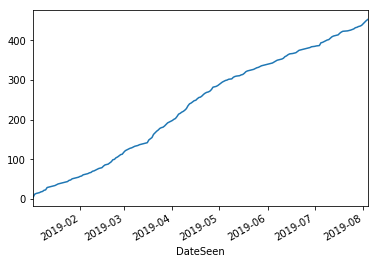

In [0]:
#merge and munge the two datasets, print out some stats

fulldf = pd.merge(df, wdf,  how='left', left_on=['Title','Year'], right_on = ['Title','Year'])

fulldf[pd.isnull(fulldf['DateSeen'])]
countseen=fulldf.dropna(subset=['DateSeen'])

totDays=abs((datetime.now() - fulldf['DateSeen'].min()).days) #based on the date of the first diary entry in the 1001 list
print('day:'+ str(totDays))

print(str(round((countseen.shape[0]/fulldf.shape[0])*100,2))+ "% seen")
print(str(round(100*sum(countseen['Runtime'])/fulldf.sum(axis=0)[6],2))+ "% seen by length")

print(str(countseen.shape[0])+ " Films seen")
print(str(round(countseen.shape[0]/totDays,2)) + " average per day")

##get a linechart of film seen Vs time
seendf=countseen.groupby(['DateSeen']).size().cumsum()
seendf.plot.line()